# FINAL MODEL AT NORMAL CONDITIONS (UNDERSHOOT)

Solving stripping column with automatic stage determination...
Solving stage 1...
Solving stage 2...
Solving stage 3...
Solving stage 4...
Solving stage 5...
Solving stage 6...
Solving stage 7...
Solving stage 8...
Solving stage 9...
Solving stage 10...
Solving stage 11...
Solving stage 12...
Solving stage 13...
Solving stage 14...
Solving stage 15...
Solving stage 16...
Solving stage 17...
Solving stage 18...
Solving stage 19...
Solving stage 20...
Solving stage 21...
Solving stage 22...
Solving stage 23...
Solving stage 24...
Solving stage 25...
Solving stage 26...
Solving stage 27...
Solving stage 28...
Solving stage 29...
Solving stage 30...
Solving stage 31...
Solving stage 32...
Solving stage 33...
Solving stage 34...
Solving stage 35...
Solving stage 36...
Solving stage 37...
Solving stage 38...
Solving stage 39...
Solving stage 40...
Solving stage 41...
Solving stage 42...
Solving stage 43...
Solving stage 44...
Solving stage 45...
Solving stage 46...
Solving stage 47...
Solvin

C:\Users\Damia\AppData\Local\Temp\ipykernel_19168\2483127171.py:225: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(equations, guess, xtol=1e-12)


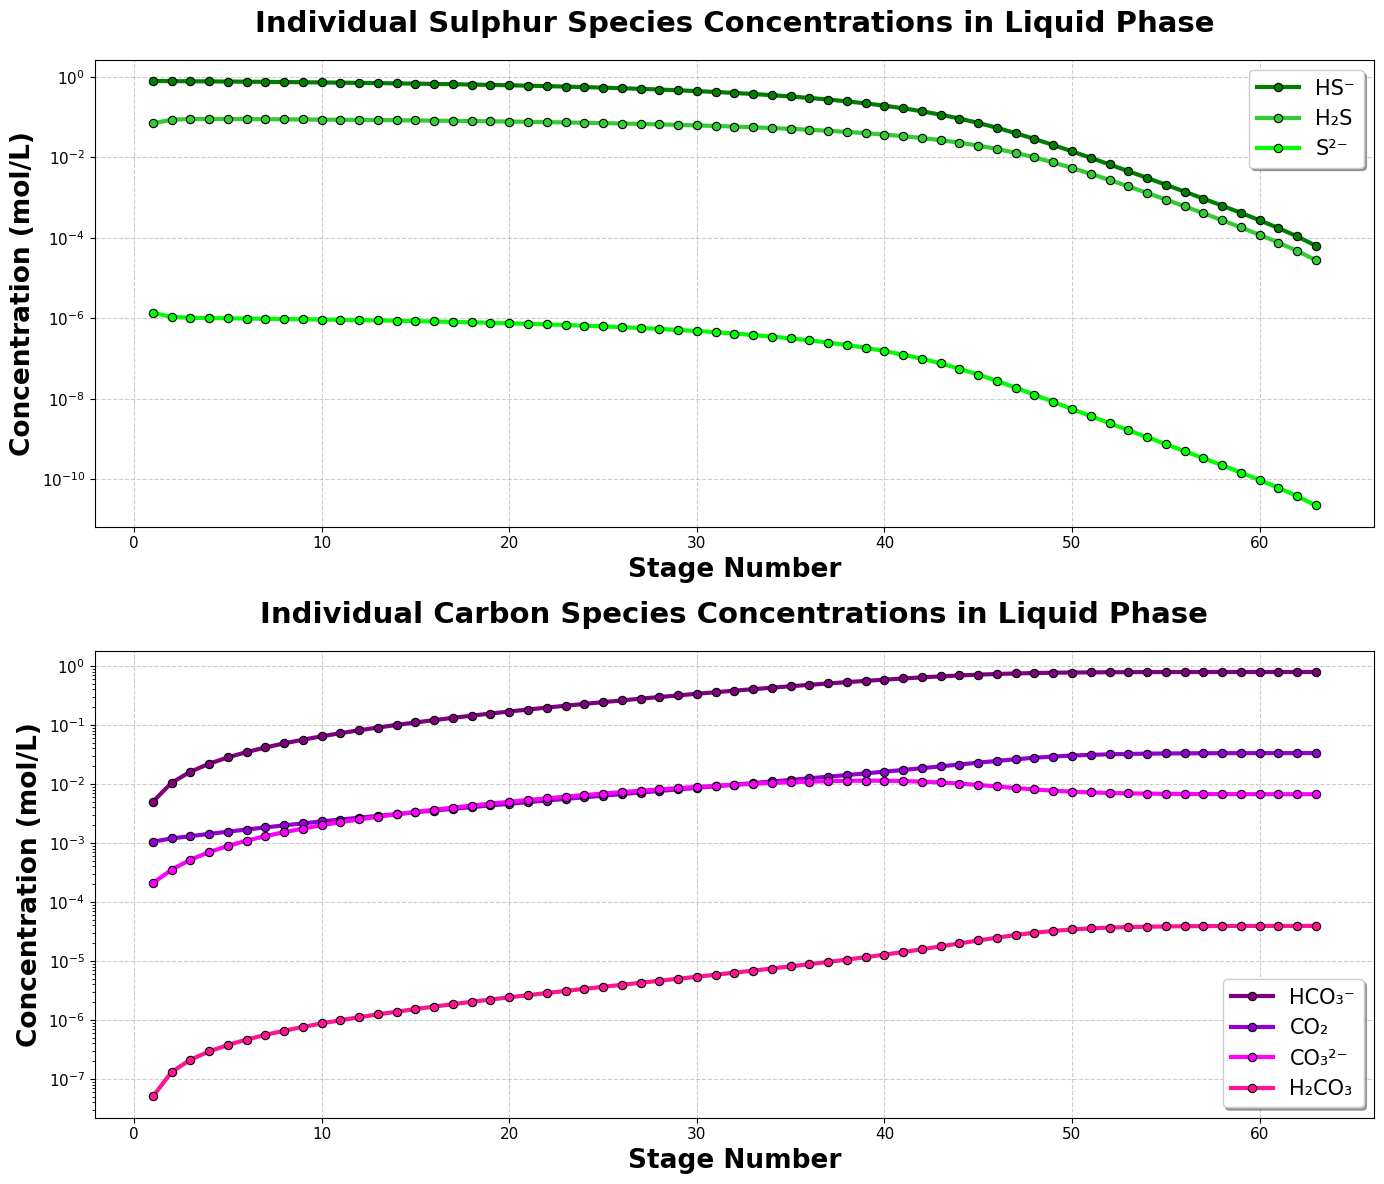

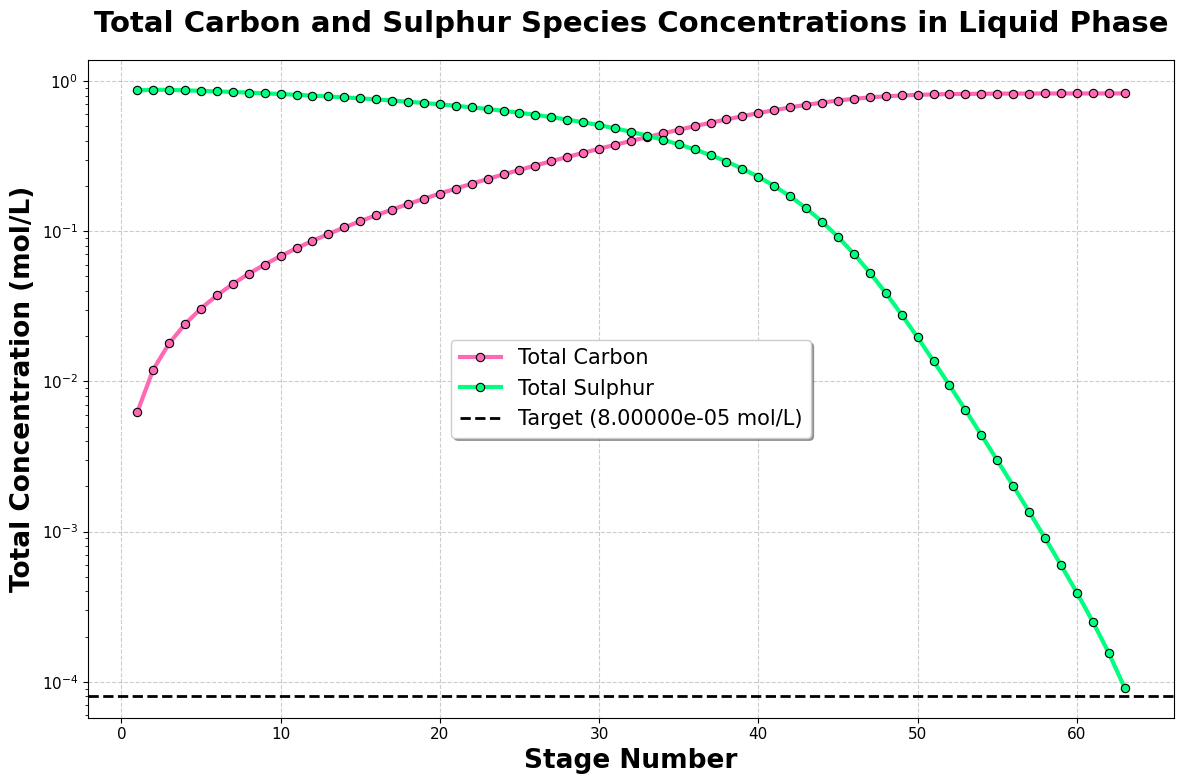

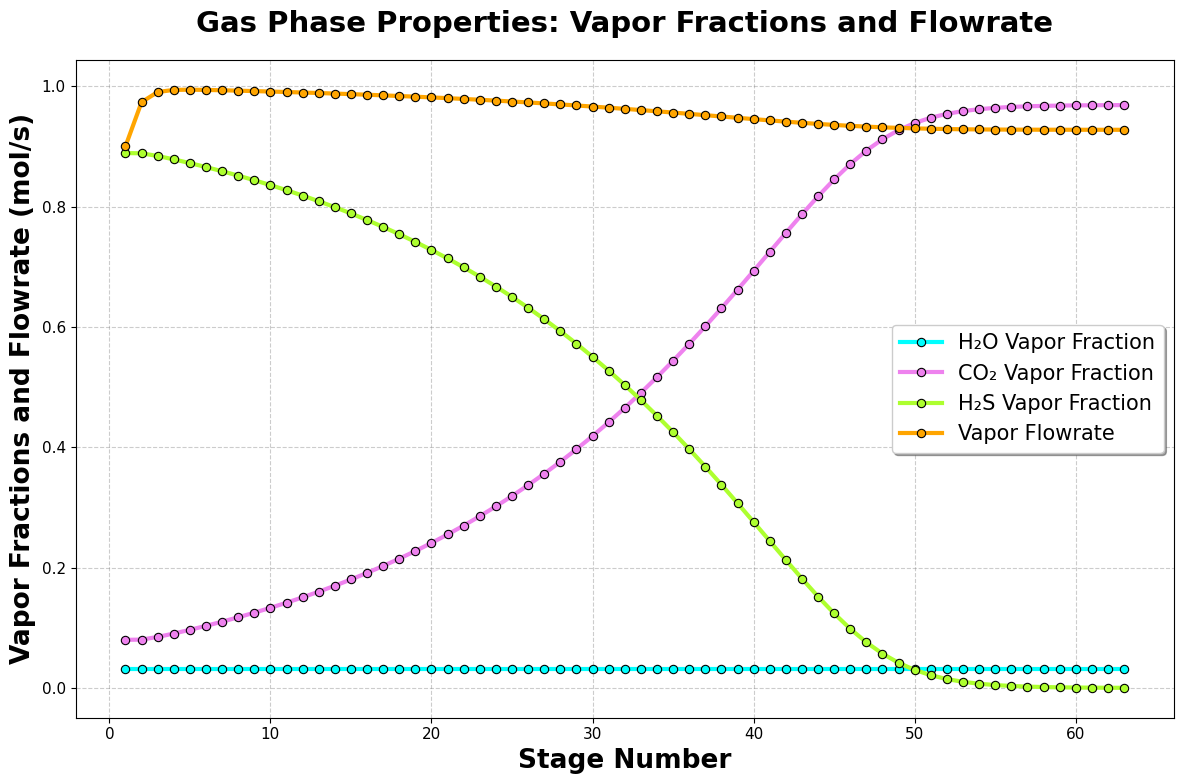

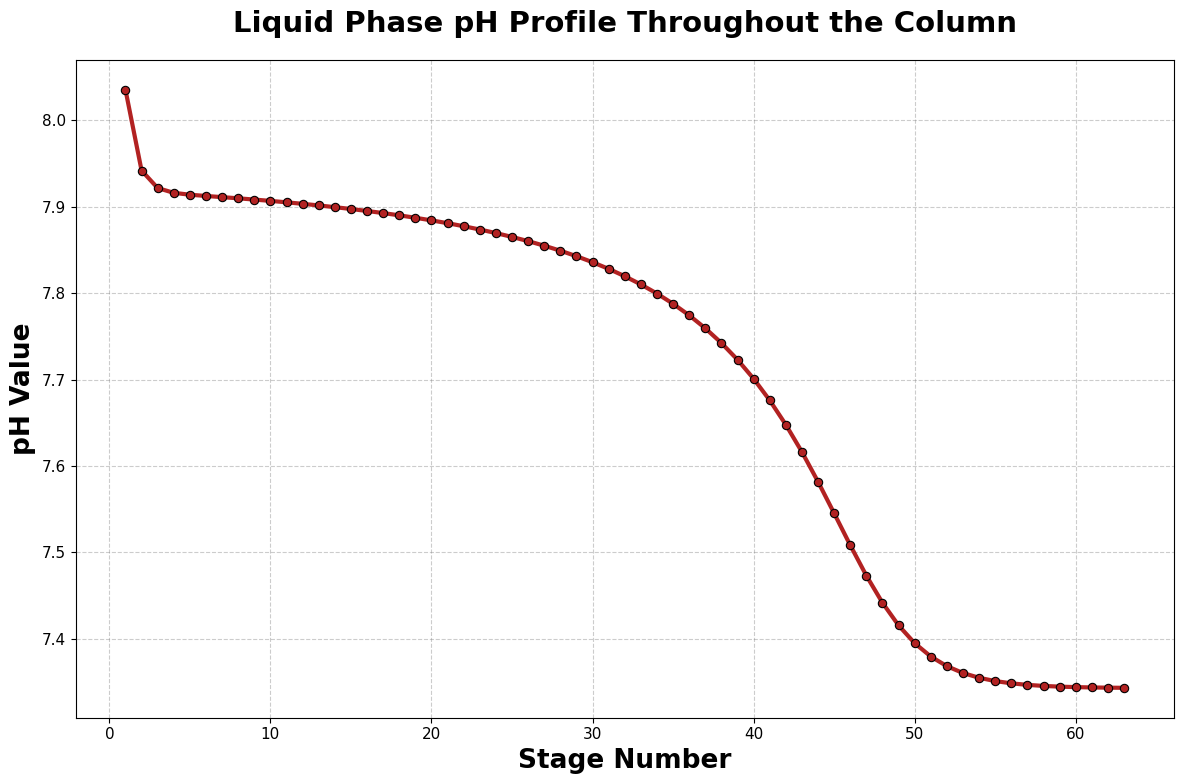

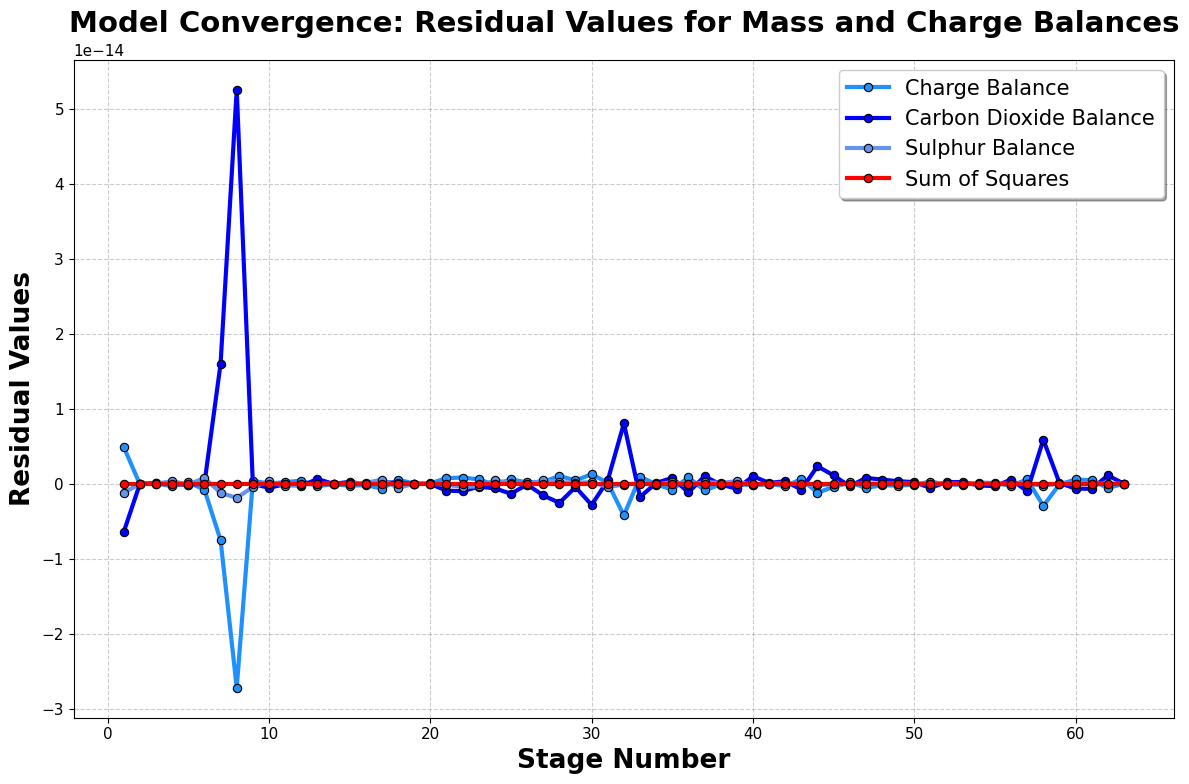

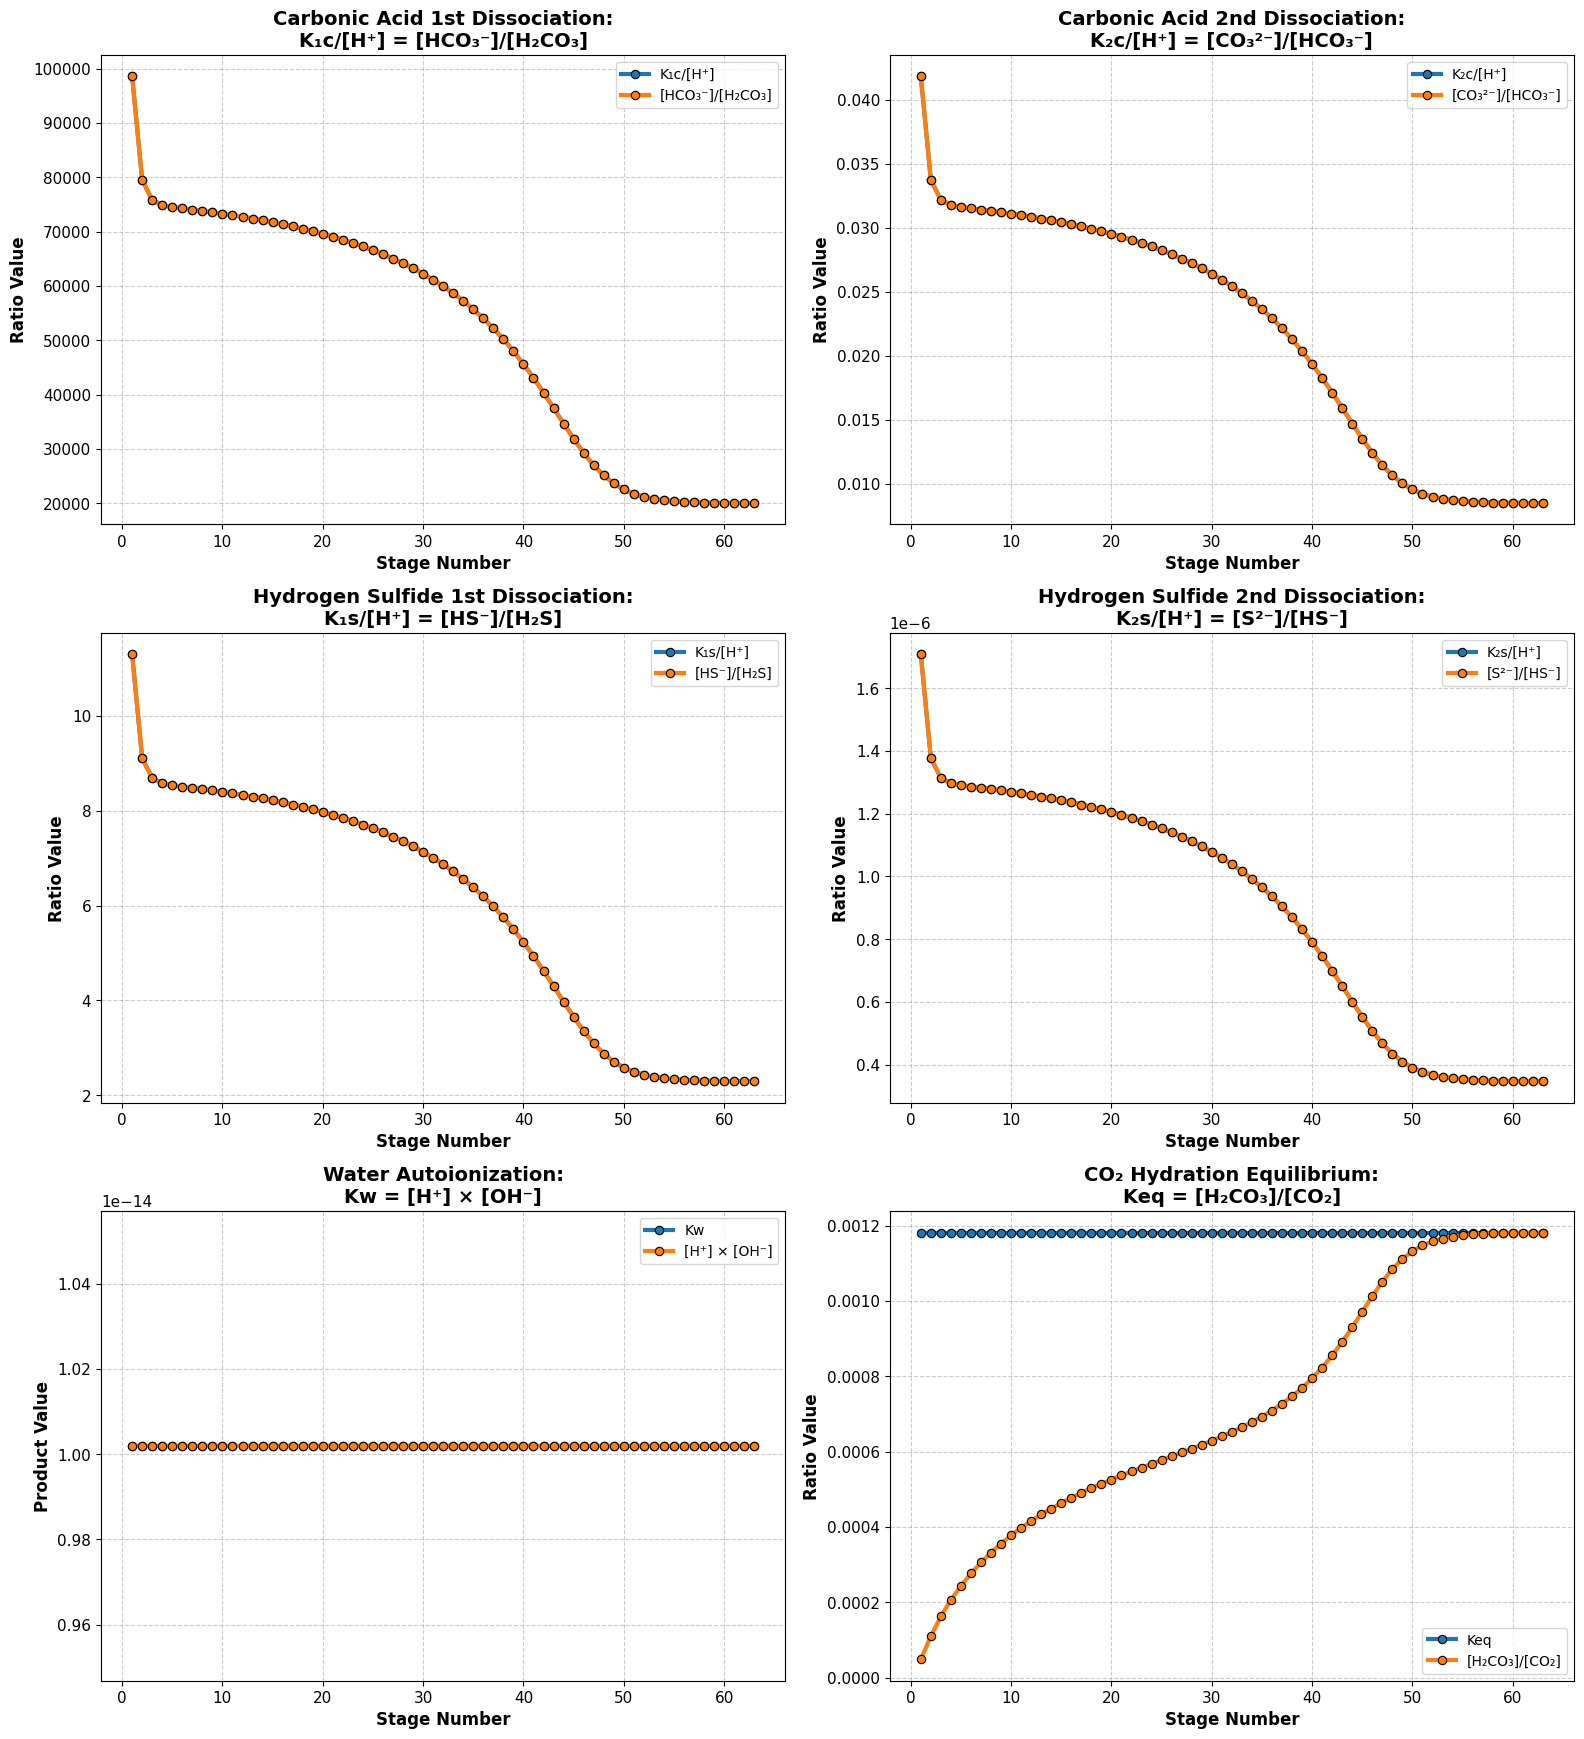

In [6]:
from scipy.optimize import fsolve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Operating conditions
T_operating = 25        # °C
P_operating = 1         # atm
V_stage = 180           # L
L_flow = 1              # L/s
G_flow_out_top = 0.9    # mol/s (from top of column)
ε_gas_fraction = 5      # %
d_bubble_mm = 5         # mm
x_H2S_recovery = 99.99  # %
max_stages = 1000       # Maximum number of stages

# Feed concentrations (at the top of column)
c_NaHS_feed = 0.8        # mol/L
c_CO2_feed = 0           # mol/L
c_H2CO3_feed = 0         # mol/L
c_HCO3_feed = 0          # mol/L
c_CO3_feed = 0           # mol/L
c_H2S_feed = 0           # mol/L
c_S_feed = 0             # mol/L

# Equilibrium constants and property functions
def K_eq(T):
    K_eq = 1/(0.04020944211255422*(np.e**(0.2130531302959603*T)) + 838.3007987989027)
    return K_eq

def K_1c(T):
    K_1c = 10**(-0.994 - (610.5/(T + 273.15)))
    return K_1c

def K_2c(T):
    K_2c = 10**(452.094 - (21263.61/(T + 273.15)) - (68.483143*np.log((T + 273.15))))
    return K_2c

def K_1s(T):
    K_1s = 10**(-32.55 - (1519.44/(T + 273.15)) + (15.672*np.log10((T + 273.15))) - (0.02722*(T + 273.15)))
    return K_1s

def K_2s(T):
    K_2s = 10**(-(4500/(T + 273.15)) - (12.6*np.log10((T + 273.15)/298.15)) + 1.29)
    return K_2s

def K_w(T):
    K_w = 10**(-(142613.6/(T + 273.15)) - (4229.195*np.log10((T + 273.15))) + (9.7384*(T + 273.15)) - 
               (0.0129638*(T + 273.15)**2) + (1.15068e-5 *(T + 273.15)**3) - (4.602e-9 *(T + 273.15)**4) + 8909.483)
    return K_w

def k_f(T):
    k_f = np.e**(22.66 - (7799/(T + 273.15)))
    return k_f

# Physical property functions
d_bubble_m = d_bubble_mm/1000
a = (6*(ε_gas_fraction/100))/d_bubble_m
g = 9.182
MM_H2O = 18.01528

def liquid_surface_tension(T):
    factor = (647.15 - (T + 273.15))/647.15
    σ_L = (235.8e-3)*(1 - 0.625*factor)*(factor**1.256)
    return σ_L

def liquid_density(T):
    ρ_L = -13.851 + (0.64038*(T + 273.15)) - (0.0019124*((T + 273.15)**2)) + ((1.8211e-6)*((T + 273.15)**3))
    return ρ_L*(MM_H2O/1000)*(10**3)

def liquid_dynamic_viscosity(T):
    μ_L = np.e**(-52.843 + (3703.6/(T + 273.15)) + (5.866*np.log(T + 273.15)) - ((5.879e-29)*((T + 273.15)**10)))
    return μ_L

def bubble_rising_velocity(T):
    σ_L = liquid_surface_tension(T)
    ρ_L = liquid_density(T)
    u_b = (((2.14*σ_L)/(d_bubble_m*ρ_L)) + (0.505*g*d_bubble_m))**0.5
    return u_b

def liquid_diffusivity_CO2(T):
    D_L_25_CO2 = (1.96e-5)/(100**2)
    μ_L_25 = liquid_dynamic_viscosity(25)
    constant_25_CO2 = D_L_25_CO2*μ_L_25/(25 + 273.15)
    D_L_CO2 = constant_25_CO2*(T + 273.15)/liquid_dynamic_viscosity(T)
    return D_L_CO2

def liquid_side_mass_transfer_coefficient_CO2(T):
    k_L_CO2 = 2*((liquid_diffusivity_CO2(T)*bubble_rising_velocity(T))/(np.pi*d_bubble_m))**0.5
    return k_L_CO2

def k_La_CO2_func(T):
    k_La_CO2 = a*liquid_side_mass_transfer_coefficient_CO2(T)
    return k_La_CO2

def liquid_diffusivity_H2S(T):
    D_L_25_H2S = (1.61e-5)/(100**2)
    μ_L_25 = liquid_dynamic_viscosity(25)
    constant_25_H2S = D_L_25_H2S*μ_L_25/(25 + 273.15)
    D_L_H2S = constant_25_H2S*(T + 273.15)/liquid_dynamic_viscosity(T)
    return D_L_H2S

def liquid_side_mass_transfer_coefficient_H2S(T):
    k_L_H2S = 2*((liquid_diffusivity_H2S(T)*bubble_rising_velocity(T))/(np.pi*d_bubble_m))**0.5
    return k_L_H2S

def k_La_H2S_func(T):
    k_La_H2S = a*liquid_side_mass_transfer_coefficient_H2S(T)
    return k_La_H2S

def P_vap_H2O(T):
    A_H2O = 4.6543
    B_H2O = 1435.264
    C_H2O = -64.848
    P_vap_H2O = 10**(A_H2O - (B_H2O / ((T + 273.15) + C_H2O)))
    return P_vap_H2O * 0.986923

def k_H_CO2(T):
    k_H_CO2_start = 0.034*np.e**(2600*((1/(T + 273.15)) - (1/298.15)))
    k_H_CO2 = k_H_CO2_start*liquid_density(T)*(1.01325/1000)
    return k_H_CO2

def k_H_H2S(T):
    k_H_H2S_start = 0.1*np.e**(2300*((1/(T + 273.15)) - (1/298.15)))
    k_H_H2S = k_H_H2S_start*liquid_density(T)*(1.01325/1000)
    return k_H_H2S

# Calculate constants at operating temperature
K_eq_val = K_eq(T_operating)
K_1c_val = K_1c(T_operating)
K_2c_val = K_2c(T_operating)
K_1s_val = K_1s(T_operating)
K_2s_val = K_2s(T_operating)
K_w_val = K_w(T_operating)
k_f_val = k_f(T_operating)
k_La_CO2 = k_La_CO2_func(T_operating)
k_La_H2S = k_La_H2S_func(T_operating)
P_vap_H2O_val = P_vap_H2O(T_operating)
k_H_CO2_val = k_H_CO2(T_operating)
k_H_H2S_val = k_H_H2S(T_operating)

def solve_stage(liquid_in, gas_out, stage_num):
    """
    Solve a single stage given liquid inlet and gas outlet conditions
    
    liquid_in: dict with liquid concentrations entering the stage
    gas_out: dict with gas flow rate and compositions leaving the stage
    stage_num: stage number (1 is top stage)
    
    Returns: liquid_out, gas_in dictionaries
    """
    
    # Extract input conditions
    c_Na_in = liquid_in['Na']
    c_H2S_in = liquid_in['H2S']
    c_HS_in = liquid_in['HS']
    c_S_in = liquid_in['S']
    c_CO2_in = liquid_in['CO2']
    c_H2CO3_in = liquid_in['H2CO3']
    c_HCO3_in = liquid_in['HCO3']
    c_CO3_in = liquid_in['CO3']
    
    G_flow_out = gas_out['flow']
    y_H2O_out = gas_out['H2O']
    y_H2S_out = gas_out['H2S']
    y_CO2_out = gas_out['CO2']
    
    # Calculate interfacial concentrations
    c_H2S_i_stage = k_H_H2S_val * y_H2S_out * P_operating
    c_CO2_i_stage = k_H_CO2_val * y_CO2_out * P_operating
    
    # Sodium is conserved
    c_Na_out = c_Na_in
    
    # Define equations for this stage with transformed variables
    def equations(vars):
        pH, y_scaled, z_scaled = vars  # pH, 1000*c_H2CO3_out, 1000*c_H2S_out
        
        # Convert back to actual concentrations
        c_H_out = 10**(-pH)
        c_H2CO3_out = y_scaled / 1000.0
        c_H2S_out = z_scaled / 1000.0
        
        # Calculate other concentrations
        c_OH_out = K_w_val / c_H_out
        c_HCO3_out = c_H2CO3_out * K_1c_val / c_H_out
        c_CO3_out = c_HCO3_out * K_2c_val / c_H_out
        c_HS_out = c_H2S_out * K_1s_val / c_H_out
        c_S_out = c_HS_out * K_2s_val / c_H_out

        c_CO2_out = ((L_flow*(c_H2CO3_out + c_HCO3_out + c_CO3_out) - L_flow*(c_H2CO3_in + c_HCO3_in + c_CO3_in)) /
                     (k_f_val*(1 - ε_gas_fraction/100)*V_stage)) + (c_H2CO3_out/K_eq_val)

        term2 = k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out) + k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out)
        G_flow_in = G_flow_out + (term2/(1 - y_H2O_out))

        y_H2S_in = ((G_flow_out*y_H2S_out) + (k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out))) / G_flow_in
        y_CO2_in = ((G_flow_out*y_CO2_out) + (k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out))) / G_flow_in

        eq1 = c_Na_out + c_H_out - c_HCO3_out - 2*c_CO3_out - c_OH_out - c_HS_out - 2*c_S_out
        eq2 = (G_flow_out*y_CO2_out + L_flow*(c_CO2_out + c_H2CO3_out + c_HCO3_out + c_CO3_out) -
               G_flow_in*y_CO2_in - L_flow*(c_CO2_in + c_H2CO3_in + c_HCO3_in + c_CO3_in))
        eq3 = (G_flow_out*y_H2S_out + L_flow*(c_H2S_out + c_HS_out + c_S_out) -
               G_flow_in*y_H2S_in - L_flow*(c_H2S_in + c_HS_in + c_S_in))

        return [eq1, eq2, eq3]

    # Try multiple initial guesses with transformed variables
    initial_guesses = [
        [7.0, 1.0, 1.0],      # pH=7, 1000*[H2CO3]=1, 1000*[H2S]=1
        [6.8, 1.2, 1.0],      # pH=6.8, 1000*[H2CO3]=1.2, 1000*[H2S]=1
        [7.2, 0.8, 1.0],      # pH=7.2, 1000*[H2CO3]=0.8, 1000*[H2S]=1
        [7.0, 1.0, 1.2],      # pH=7, 1000*[H2CO3]=1, 1000*[H2S]=1.2
        [7.0, 1.0, 0.8],      # pH=7, 1000*[H2CO3]=1, 1000*[H2S]=0.8
        [6.5, 1.5, 1.5],      # pH=6.5, 1000*[H2CO3]=1.5, 1000*[H2S]=1.5
        [7.5, 0.5, 0.5],      # pH=7.5, 1000*[H2CO3]=0.5, 1000*[H2S]=0.5
    ]
    
    best_solution = None
    best_residual = 1e10
    best_equations_residual = None

    for guess in initial_guesses:
        try:
            solution = fsolve(equations, guess, xtol=1e-12)
            residual_vals = equations(solution)
            residual = sum([r**2 for r in residual_vals])
            
            # Check if solution is physically reasonable
            pH_val, y_scaled_val, z_scaled_val = solution
            c_H_val = 10**(-pH_val)
            c_H2CO3_val = y_scaled_val / 1000.0
            c_H2S_val = z_scaled_val / 1000.0
            
            # Physical constraints
            if (4 <= pH_val <= 14 and c_H2CO3_val > 0 and c_H2S_val > 0 and 
                y_scaled_val > 0 and z_scaled_val > 0 and residual < best_residual):
                best_residual = residual
                best_solution = solution
                best_equations_residual = residual_vals
        except:
            continue

    if best_solution is None:
        raise ValueError(f"Could not converge stage {stage_num}")

    # Extract solution and convert back to actual concentrations
    pH_out, y_scaled_out, z_scaled_out = best_solution
    c_H_out = 10**(-pH_out)
    c_H2CO3_out = y_scaled_out / 1000.0
    c_H2S_out = z_scaled_out / 1000.0
    
    # Calculate derived concentrations
    c_OH_out = K_w_val / c_H_out
    c_HCO3_out = c_H2CO3_out * K_1c_val / c_H_out
    c_CO3_out = c_HCO3_out * K_2c_val / c_H_out
    c_HS_out = c_H2S_out * K_1s_val / c_H_out
    c_S_out = c_HS_out * K_2s_val / c_H_out
    
    c_CO2_out = ((L_flow*(c_H2CO3_out + c_HCO3_out + c_CO3_out) - L_flow*(c_H2CO3_in + c_HCO3_in + c_CO3_in)) /
                 (k_f_val*(1 - ε_gas_fraction/100)*V_stage)) + (c_H2CO3_out/K_eq_val)
    
    term2 = k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out) + k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out)
    G_flow_in = G_flow_out + (term2/(1 - y_H2O_out))
    
    y_H2S_in = ((G_flow_out*y_H2S_out) + (k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out))) / G_flow_in
    y_CO2_in = ((G_flow_out*y_CO2_out) + (k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out))) / G_flow_in
    y_H2O_in = y_H2O_out
    
    # Package outputs
    liquid_out = {
        'Na': c_Na_out,
        'H': c_H_out,
        'OH': c_OH_out,
        'CO2': c_CO2_out,
        'H2CO3': c_H2CO3_out,
        'HCO3': c_HCO3_out,
        'CO3': c_CO3_out,
        'H2S': c_H2S_out,
        'HS': c_HS_out,
        'S': c_S_out,
        'pH': pH_out
    }
    
    gas_in = {
        'flow': G_flow_in,
        'H2O': y_H2O_in,
        'CO2': y_CO2_in,
        'H2S': y_H2S_in
    }
    
    # Return individual residuals for plotting
    residuals = {
        'cb': best_equations_residual[0],   # Charge balance
        'cdb': best_equations_residual[1],  # Carbon dioxide balance
        'sb': best_equations_residual[2]    # Sulphur balance
    }
    
    return liquid_out, gas_in, best_residual, residuals

# Initialize column simulation
print("="*120)
print("Solving stripping column with automatic stage determination...")
print("="*120)

# Initialize liquid feed at top (stage 1)
liquid_feed = {
    'Na': c_NaHS_feed,
    'H2S': c_H2S_feed,
    'HS': c_NaHS_feed,  # Initial HS- from NaHS feed
    'S': c_S_feed,
    'CO2': c_CO2_feed,
    'H2CO3': c_H2CO3_feed,
    'HCO3': c_HCO3_feed,
    'CO3': c_CO3_feed
}

# Initialize gas outlet from top (stage 1)
y_H2O_top = P_vap_H2O_val/P_operating
y_H2S_top = ((x_H2S_recovery/100)*c_NaHS_feed*L_flow)/G_flow_out_top
y_CO2_top = 1 - y_H2O_top - y_H2S_top

gas_top = {
    'flow': G_flow_out_top,
    'H2O': y_H2O_top,
    'CO2': y_CO2_top,
    'H2S': y_H2S_top
}

# Calculate target sulphur remaining in liquid (what should NOT be stripped)
total_sulphur_feed = c_NaHS_feed  # mol/L of sulphur from NaHS
target_sulphur_remaining = total_sulphur_feed * (1 - x_H2S_recovery/100)

# Storage for results
stage_results = {}
liquid_profiles = []
gas_profiles = []
residual_profiles = []

# Solve column from top to bottom
current_liquid = liquid_feed.copy()
current_gas = gas_top.copy()

# Convergence criteria
converged = False
final_stage = 0
previous_total_sulphur = None  # Track previous stage sulphur content

for stage in range(1, max_stages + 1):
    print(f"Solving stage {stage}...")
    
    try:
        liquid_out, gas_in, residual, residuals = solve_stage(current_liquid, current_gas, stage)
        
        # Calculate sulphur mass balance for this stage
        total_sulphur_out = liquid_out['H2S'] + liquid_out['HS'] + liquid_out['S']
        
        # Check if we should stop BEFORE reaching the target
        if previous_total_sulphur is not None:
            # If current stage would go below target, stop at previous stage
            if total_sulphur_out <= target_sulphur_remaining:
                print(f"\n*** CONVERGED at stage {stage-1} (stopping just before target) ***")
                print(f"Target sulphur remaining: {target_sulphur_remaining:.6e} mol/L")
                print(f"Stage {stage-1} sulphur remaining: {previous_total_sulphur:.6e} mol/L")
                print(f"Stage {stage} would have: {total_sulphur_out:.6e} mol/L")
                converged = True
                final_stage = stage - 1
                break
        
        # Store results for this stage
        stage_results[stage] = {
            'liquid_in': current_liquid.copy(),
            'liquid_out': liquid_out.copy(),
            'gas_in': gas_in.copy(),
            'gas_out': current_gas.copy(),
            'residual': residual,
            'residuals': residuals
        }
        
        liquid_profiles.append({
            'stage': stage,
            **liquid_out
        })
        
        gas_profiles.append({
            'stage': stage,
            'flow_in': gas_in['flow'],
            'flow_out': current_gas['flow'],
            'y_H2O_in': gas_in['H2O'],
            'y_CO2_in': gas_in['CO2'],
            'y_H2S_in': gas_in['H2S'],
            'y_H2O_out': current_gas['H2O'],
            'y_CO2_out': current_gas['CO2'],
            'y_H2S_out': current_gas['H2S']
        })
        
        residual_profiles.append({
            'stage': stage,
            'cb': residuals['cb'],
            'cdb': residuals['cdb'],
            'sb': residuals['sb']
        })
        
        # Store current sulphur content for next iteration
        previous_total_sulphur = total_sulphur_out
        
        # Update for next stage
        current_liquid = liquid_out.copy()
        current_gas = gas_in.copy()
        
    except Exception as e:
        print(f"Error solving stage {stage}: {e}")
        break

if not converged:
    print(f"\nWARNING: Did not converge within {max_stages} stages")
    final_stage = len(liquid_profiles)
else:
    print(f"\nColumn converged within {final_stage} stages")

print("="*120)
print("Column solution complete!")

# Convert to DataFrames for easier analysis
df_liquid = pd.DataFrame(liquid_profiles)
df_gas = pd.DataFrame(gas_profiles)
df_residuals = pd.DataFrame(residual_profiles)

# Calculate actual recovery achieved
if final_stage > 0:
    final_liquid = stage_results[final_stage]['liquid_out']
    final_sulphur_remaining = final_liquid['H2S'] + final_liquid['HS'] + final_liquid['S']
    actual_recovery = (1 - final_sulphur_remaining/total_sulphur_feed) * 100
    
    print(f"\nFINAL PERFORMANCE:")
    print(f"Operating temperature: {T_operating} °C")
    print(f"Operating pressure: {P_operating} atm")
    print(f"Number of stages required: {final_stage}")
    print(f"Actual H2S recovery: {actual_recovery:.5f} %")
    print(f"Target H2S recovery: {x_H2S_recovery:.5f} %")
    print(f"Final sulphur remaining: {final_sulphur_remaining:.6e} mol/L")
    print(f"Target sulphur remaining: {target_sulphur_remaining:.6e} mol/L")

# Display detailed results for key stages
if final_stage >= 1:
    print("\n" + "="*120)
    print("DETAILED RESULTS FOR STAGE 1 (TOP OF COLUMN - FEED STAGE)")
    print("="*120)
    
    stage_1 = stage_results[1]
    
    print("LIQUID INLET CONDITIONS (FEED):")
    for key, value in stage_1['liquid_in'].items():
        if isinstance(value, float):
            print(f"  {key:8s}: {value:.8e} mol/L")
    
    print("\nLIQUID OUTLET CONDITIONS:")
    for key, value in stage_1['liquid_out'].items():
        if key == 'pH':
            print(f"  {key:8s}: {value:.4f}")
        elif isinstance(value, float):
            print(f"  {key:8s}: {value:.8e} mol/L")
            
    print(f"\nSUM OF THE SQUARES OF THE BALANCE EQUATIONS: {stage_1['residual']:.2e}")

if final_stage >= 2:
    print("\n" + "="*120)
    print(f"DETAILED RESULTS FOR STAGE {final_stage} (BOTTOM OF COLUMN)")
    print("="*120)
    
    stage_last = stage_results[final_stage]
    
    print("LIQUID OUTLET CONDITIONS (FINAL):")
    for key, value in stage_last['liquid_out'].items():
        if key == 'pH':
            print(f"  {key:8s}: {value:.4f}")
        elif isinstance(value, float):
            print(f"  {key:8s}: {value:.8e} mol/L")
    
    print(f"\nSUM OF THE SQUARES OF THE BALANCE EQUATIONS: {stage_last['residual']:.2e}")

# ===============================================================================
# SYSTEM PROPERTIES
# ===============================================================================

print('')
print("="*120)
print("SYSTEM PROPERTIES")
print("="*120)
print('')
print('~~~~~ EQUILIBRIUM CONSTANTS ~~~~~')
print("K_eq (@", T_operating, "°C) =", K_eq_val)
print("K_1c (@", T_operating, "°C) =", K_1c_val)
print("K_2c (@", T_operating, "°C) =", K_2c_val)
print("K_1s (@", T_operating, "°C) =", K_1s_val)
print("K_2s (@", T_operating, "°C) =", K_2s_val)
print("K_w (@", T_operating, "°C)  =", K_w_val)
print('')
print('~~~~~ FORWARD RATE CONSTANT ~~~~~')
print("k_f (@", T_operating, "°C)  =", k_f_val, "s^-1")
print('')
print('~~~~~ FLUID PROPERTIES ~~~~~')
print("a =", a, "1/m")
print("σ_L (@", T_operating, "°C) =", liquid_surface_tension(T_operating), "N/m")
print("ρ_L (@", T_operating, "°C) =", liquid_density(T_operating), "kg/m^3")
print("μ_L (@", T_operating, "°C) =", liquid_dynamic_viscosity(T_operating), "Pa.s")
print("u_b (@", T_operating, "°C) =", bubble_rising_velocity(T_operating), "m/s")
print('')
print('~~~~~ MASS TRANSFER COEFFICIENT FOR CO2 ~~~~~')
print("k_La_CO2 (@", T_operating, "°C) =", k_La_CO2, "s^-1")
print('')
print('~~~~~ MASS TRANSFER COEFFICIENT FOR H2S ~~~~~')
print("k_La_H2S (@", T_operating, "°C) =", k_La_H2S, "s^-1")
print('')
print('~~~~~ HENRY COEFFICIENT FOR CO2 ~~~~~')
print("k_H_CO2 (@", T_operating, "°C) =", k_H_CO2_val, "mol/L.atm")
print('')
print('~~~~~ HENRY COEFFICIENT FOR H2S ~~~~~')
print("k_H_H2S (@", T_operating, "°C) =", k_H_H2S_val, "mol/L.atm")
print('')
print('~~~~~ VAPOR PRESSURE FOR H2O ~~~~~')
print("P_vap_H2O (@", T_operating, "°C) =", P_vap_H2O_val, "atm")
print('')

# ===============================================================================
# PLOTTING SECTION
# ===============================================================================

print("="*120)
print("PLOTTING SECTION")
print("="*120)

# Matplotlib parameters for plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11

# 1. INDIVIDUAL LIQUID CONCENTRATIONS PLOTS
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Sulphur species
ax1.semilogy(df_liquid['stage'], df_liquid['HS'], 'o-', label='HS⁻', linewidth=3, markersize=6, color='green', 
             markeredgecolor='black', markeredgewidth=0.8)
ax1.semilogy(df_liquid['stage'], df_liquid['H2S'], 'o-', label='H₂S', linewidth=3, markersize=6, color='limegreen', 
             markeredgecolor='black', markeredgewidth=0.8)
ax1.semilogy(df_liquid['stage'], df_liquid['S'], 'o-', label='S²⁻', linewidth=3, markersize=6, color='lime', 
             markeredgecolor='black', markeredgewidth=0.8)
ax1.set_xlabel('Stage Number', fontsize=19, fontweight='bold')
ax1.set_ylabel('Concentration (mol/L)', fontsize=19, fontweight='bold')
ax1.set_title('Individual Sulphur Species Concentrations in Liquid Phase', fontsize=21, fontweight='bold', pad=20)
ax1.legend(fontsize=15, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')

# Carbon species
ax2.semilogy(df_liquid['stage'], df_liquid['HCO3'], 'o-', label='HCO₃⁻', linewidth=3, markersize=6, color='purple', 
             markeredgecolor='black', markeredgewidth=0.8)
ax2.semilogy(df_liquid['stage'], df_liquid['CO2'], 'o-', label='CO₂', linewidth=3, markersize=6, color='darkviolet', 
             markeredgecolor='black', markeredgewidth=0.8)
ax2.semilogy(df_liquid['stage'], df_liquid['CO3'], 'o-', label='CO₃²⁻', linewidth=3, markersize=6, color='magenta', 
             markeredgecolor='black', markeredgewidth=0.8)
ax2.semilogy(df_liquid['stage'], df_liquid['H2CO3'], 'o-', label='H₂CO₃', linewidth=3, markersize=6, color='deeppink', 
             markeredgecolor='black', markeredgewidth=0.8)
ax2.set_xlabel('Stage Number', fontsize=19, fontweight='bold')
ax2.set_ylabel('Concentration (mol/L)', fontsize=19, fontweight='bold')
ax2.set_title('Individual Carbon Species Concentrations in Liquid Phase', fontsize=21, fontweight='bold', pad=20)
ax2.legend(fontsize=15, frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')

plt.tight_layout()
plt.show()

# 2. TOTAL LIQUID CONCENTRATIONS PLOT
plt.figure(figsize=(12, 8))
total_sulphur = df_liquid['H2S'] + df_liquid['HS'] + df_liquid['S']
total_carbon = df_liquid['CO2'] + df_liquid['H2CO3'] + df_liquid['HCO3'] + df_liquid['CO3']
plt.semilogy(df_liquid['stage'], total_carbon, 'o-', label='Total Carbon', linewidth=3, markersize=6, 
             color='hotpink', markeredgecolor='black', markeredgewidth=0.8)
plt.semilogy(df_liquid['stage'], total_sulphur, 'o-', label='Total Sulphur', linewidth=3, markersize=6, 
             color='springgreen', markeredgecolor='black', markeredgewidth=0.8)
plt.axhline(y=target_sulphur_remaining, linestyle='--', linewidth=2, label=f'Target ({target_sulphur_remaining:.5e} mol/L)', 
            color='black')
plt.xlabel('Stage Number', fontsize=19, fontweight='bold')
plt.ylabel('Total Concentration (mol/L)', fontsize=19, fontweight='bold')
plt.title('Total Carbon and Sulphur Species Concentrations in Liquid Phase', fontsize=21, fontweight='bold', pad=20)
plt.legend(fontsize=15, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
plt.tight_layout()
plt.show()

# 3. GAS PHASE PROPERTIES PLOT
plt.figure(figsize=(12, 8))
plt.plot(df_gas['stage'], df_gas['y_H2O_out'], 'o-', label='H₂O Vapor Fraction', linewidth=3, markersize=6, 
         color='cyan', markeredgecolor='black', markeredgewidth=0.8)
plt.plot(df_gas['stage'], df_gas['y_CO2_out'], 'o-', label='CO₂ Vapor Fraction', linewidth=3, markersize=6, 
         color='violet', markeredgecolor='black', markeredgewidth=0.8)
plt.plot(df_gas['stage'], df_gas['y_H2S_out'], 'o-', label='H₂S Vapor Fraction', linewidth=3, markersize=6, 
         color='greenyellow', markeredgecolor='black', markeredgewidth=0.8)
plt.plot(df_gas['stage'], df_gas['flow_out'], 'o-', label='Vapor Flowrate', linewidth=3, markersize=6, 
         color='orange', markeredgecolor='black', markeredgewidth=0.8)
plt.xlabel('Stage Number', fontsize=19, fontweight='bold')
plt.ylabel('Vapor Fractions and Flowrate (mol/s)', fontsize=19, fontweight='bold')
plt.title('Gas Phase Properties: Vapor Fractions and Flowrate', fontsize=21, fontweight='bold', pad=20)
plt.legend(fontsize=15, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
plt.tight_layout()
plt.show()

# 4. pH PROFILE PLOT
plt.figure(figsize=(12, 8))
plt.plot(df_liquid['stage'], df_liquid['pH'], 'o-', linewidth=3, markersize=6, color='firebrick', 
             markeredgecolor='black', markeredgewidth=0.8)
plt.xlabel('Stage Number', fontsize=19, fontweight='bold')
plt.ylabel('pH Value', fontsize=19, fontweight='bold')
plt.title('Liquid Phase pH Profile Throughout the Column', fontsize=21, fontweight='bold', pad=20)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
plt.tight_layout()
plt.show()

# 5. RESIDUALS PLOT
plt.figure(figsize=(12, 8))
sum_of_squares = (df_residuals['cb']**2) + (df_residuals['cdb']**2) + (df_residuals['sb']**2)
plt.plot(df_gas['stage'], df_residuals['cb'], 'o-', label='Charge Balance', linewidth=3, markersize=6, 
         color='dodgerblue', markeredgecolor='black', markeredgewidth=0.8)
plt.plot(df_gas['stage'], df_residuals['cdb'], 'o-', label='Carbon Dioxide Balance', linewidth=3, markersize=6, 
         color='blue', markeredgecolor='black', markeredgewidth=0.8)
plt.plot(df_gas['stage'], df_residuals['sb'], 'o-', label='Sulphur Balance', linewidth=3, markersize=6, 
         color='cornflowerblue', markeredgecolor='black', markeredgewidth=0.8)
plt.plot(df_gas['stage'], sum_of_squares, 'o-', label='Sum of Squares', linewidth=3, markersize=6, 
         color='red', markeredgecolor='black', markeredgewidth=0.8)
plt.xlabel('Stage Number', fontsize=19, fontweight='bold')
plt.ylabel('Residual Values', fontsize=19, fontweight='bold')
plt.title('Model Convergence: Residual Values for Mass and Charge Balances', fontsize=21, fontweight='bold', pad=20)
plt.legend(fontsize=15, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
plt.tight_layout()
plt.show()

# 6. EQUILIBRIUM CONSTANT VALIDATION (SANITY CHECKS)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 18))

# CHECK 1: Carbonic acid first dissociation
ax1.plot(df_liquid['stage'], K_1c_val/df_liquid['H'], 'o-', label='K₁c/[H⁺]', linewidth=3, markersize=6, 
             markeredgecolor='black', markeredgewidth=0.8)
ax1.plot(df_liquid['stage'], df_liquid['HCO3']/df_liquid['H2CO3'], 'o-', label='[HCO₃⁻]/[H₂CO₃]', linewidth=3, 
         markersize=6, markeredgecolor='black', markeredgewidth=0.8)
ax1.set_xlabel('Stage Number', fontsize=12, fontweight='bold')
ax1.set_ylabel('Ratio Value', fontsize=12, fontweight='bold')
ax1.set_title('Carbonic Acid 1st Dissociation:\nK₁c/[H⁺] = [HCO₃⁻]/[H₂CO₃]', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, frameon=True)
ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')

# CHECK 2: Carbonic acid second dissociation
ax2.plot(df_liquid['stage'], K_2c_val/df_liquid['H'], 'o-', label='K₂c/[H⁺]', linewidth=3, markersize=6, 
             markeredgecolor='black', markeredgewidth=0.8)
ax2.plot(df_liquid['stage'], df_liquid['CO3']/df_liquid['HCO3'], 'o-', label='[CO₃²⁻]/[HCO₃⁻]', linewidth=3, 
         markersize=6, markeredgecolor='black', markeredgewidth=0.8)
ax2.set_xlabel('Stage Number', fontsize=12, fontweight='bold')
ax2.set_ylabel('Ratio Value', fontsize=12, fontweight='bold')
ax2.set_title('Carbonic Acid 2nd Dissociation:\nK₂c/[H⁺] = [CO₃²⁻]/[HCO₃⁻]', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, frameon=True)
ax2.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')

# CHECK 3: Hydrogen sulfide first dissociation
ax3.plot(df_liquid['stage'], K_1s_val/df_liquid['H'], 'o-', label='K₁s/[H⁺]', linewidth=3, markersize=6, 
             markeredgecolor='black', markeredgewidth=0.8)
ax3.plot(df_liquid['stage'], df_liquid['HS']/df_liquid['H2S'], 'o-', label='[HS⁻]/[H₂S]', linewidth=3, markersize=6, 
             markeredgecolor='black', markeredgewidth=0.8)
ax3.set_xlabel('Stage Number', fontsize=12, fontweight='bold')
ax3.set_ylabel('Ratio Value', fontsize=12, fontweight='bold')
ax3.set_title('Hydrogen Sulfide 1st Dissociation:\nK₁s/[H⁺] = [HS⁻]/[H₂S]', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10, frameon=True)
ax3.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')

# CHECK 4: Hydrogen sulfide second dissociation
ax4.plot(df_liquid['stage'], K_2s_val/df_liquid['H'], 'o-', label='K₂s/[H⁺]', linewidth=3, markersize=6, 
             markeredgecolor='black', markeredgewidth=0.8)
ax4.plot(df_liquid['stage'], df_liquid['S']/df_liquid['HS'], 'o-', label='[S²⁻]/[HS⁻]', linewidth=3, markersize=6, 
             markeredgecolor='black', markeredgewidth=0.8)
ax4.set_xlabel('Stage Number', fontsize=12, fontweight='bold')
ax4.set_ylabel('Ratio Value', fontsize=12, fontweight='bold')
ax4.set_title('Hydrogen Sulfide 2nd Dissociation:\nK₂s/[H⁺] = [S²⁻]/[HS⁻]', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10, frameon=True)
ax4.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')

# CHECK 5: Water autoionization
ax5.plot(df_liquid['stage'], len(df_liquid['stage'])*[K_w_val], 'o-', label='Kw', linewidth=3, markersize=6, 
             markeredgecolor='black', markeredgewidth=0.8)
ax5.plot(df_liquid['stage'], df_liquid['H']*df_liquid['OH'], 'o-', label='[H⁺] × [OH⁻]', linewidth=3, markersize=6, 
             markeredgecolor='black', markeredgewidth=0.8)
ax5.set_xlabel('Stage Number', fontsize=12, fontweight='bold')
ax5.set_ylabel('Product Value', fontsize=12, fontweight='bold')
ax5.set_title('Water Autoionization:\nKw = [H⁺] × [OH⁻]', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10, frameon=True)
ax5.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')

# CHECK 6: CO2 hydration equilibrium
ax6.plot(df_liquid['stage'], len(df_liquid['stage'])*[K_eq_val], 'o-', label='Keq', linewidth=3, markersize=6, 
             markeredgecolor='black', markeredgewidth=0.8)
ax6.plot(df_liquid['stage'], df_liquid['H2CO3']/df_liquid['CO2'], 'o-', label='[H₂CO₃]/[CO₂]', linewidth=3, markersize=6, 
             markeredgecolor='black', markeredgewidth=0.8)
ax6.set_xlabel('Stage Number', fontsize=12, fontweight='bold')
ax6.set_ylabel('Ratio Value', fontsize=12, fontweight='bold')
ax6.set_title('CO₂ Hydration Equilibrium:\nKeq = [H₂CO₃]/[CO₂]', fontsize=14, fontweight='bold')
ax6.legend(fontsize=10, frameon=True)
ax6.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()